# Portfolio Optimization with the Quantum Approximate Optimization Algorithm (QAOA)

## Introduction

Portfolio optimization [[1](#PortfolioWiki)] is the process of allocating a portfolio of financial assets optimally, according to some predetermined goal. Usually, the goal is to maximize the potential return while minimizing the financial risk of the portfolio. One can express this problem as a combinatorial optimization problem like many other real-world problems. In this demo, we'll show how the Quantum Approximate Optimization Algorithm (QAOA) [[2](#QAOA)] can be employed on the Classiq platform to solve the problem of portfolio optimization.

### Modeling the Portfolio Optimization Problem

As a first step, we have to model the problem mathematically. We will use a simple yet powerful model, which captures the essence of portfolio optimization:

- A portfolio is built from a pool of $n$ financial assets, each asset labeled $i \in \{1,\ldots,n\}$.
- Every asset's return is a random variable, with expected value $\mu_i$ and variance $\Sigma_i$ (modeling the financial risk involved in the asset).
- Every two assets $i \neq j$ have covariance $\Sigma_{ij}$ (modeling market correlation between assets).
- Every asset $i$ has a weight $w_i \in D_i = \{0,\ldots,b_i\}$ in the portfolio, with $b_i$ defined as the budget for asset $i$ (modeling the maximum allowed weight of the asset).
- The return vector $\mu$, the covariance matrix $\Sigma$ and the weight vector $w$ are defined naturally from the above (with the domain $D = D_1 \times D_2 \times \ldots \times D_n$ for $w$).

With the above definitions, the total expected return of the portfolio is $\mu^T w$ and the total risk is $w^T \Sigma w$. We'll use a simple difference of the two as our cost function, with the additional constraint that the total sum of assets does not exceed a predefined budget $B$. We note that there are many other possibilities for defining a cost function (e.g. add a scaling factor to the risk/return or even some non-linear relation). For reasons of simplicity we select the model below, and we assume all constants and variables are dimensionless.
Thus, the problem is, given the constant inputs $\mu, \Sigma, D, B$, to find optimal variable $w$ as follows:

$\begin{equation*}
\min_{w \in D}  w^T \Sigma w - \mu^T w,
\end{equation*}$
subject to $\Sigma_{i} w_i \leq B$.

The case presented above is called integer portfolio optimization, since the domains $D_i$ are over the (positive) integers.
Another variation of this problem defines weights over binary domains, and will not be discussed here.


## Setup

With the mathematical definition in place, we begin the implementation by importing necessary packages and classes. We will use the following external dependencies:

1. NumPy
2. Matplotlib
3. Pyomo - a python framework for modeling optimization problems, which the Classiq platform uses as an interface to these types of problems.

From the `classiq` package, we require classes related to combinatorial optimization and QAOA.


In [1]:
import numpy as np
import pyomo.core as pyo

# The Portfolio Optimization Problem Parameters

First we define the parameters of the optimization problem, which include the expected return vector, the covariance matrix and the total budget:

In [2]:
returns = np.array([3, 4, -1])
covariances = np.array(
    [
        [0.9, 0.5, -0.7],
        [0.5, 0.9, -0.2],
        [-0.7, -0.2, 0.9],
    ]
)

total_budget = 6

## The Pyomo Model for the Problem

We proceed by defining the Pyomo model that will be used on the Classiq platform, using the problem parameters defined above:

In [3]:
portfolio_model = pyo.ConcreteModel("portfolio_optimization")
num_assets = len(returns)

# setting the variables
portfolio_model.w = pyo.Var(range(num_assets), domain=pyo.Integers, bounds=(0, 6))

w_array = list(portfolio_model.w.values())

# global budget constraint
portfolio_model.budget_rule = pyo.Constraint(expr=(sum(w_array) <= total_budget))

# setting the expected return and risk
portfolio_model.expected_return = returns @ w_array
portfolio_model.risk = w_array @ covariances @ w_array

# setting the cost function to minimize
portfolio_model.cost = pyo.Objective(
    expr=portfolio_model.risk - portfolio_model.expected_return, sense=pyo.minimize
)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` python class. Under the hood it tranlates the Pyomo model to a quantum model of the QAOA algorithm, with cost hamiltonian translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=portfolio_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "portfolio_optimization")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Opening: https://nightly.platform.classiq.io/circuit/79e25a43-a916-476c-a108-022dfec85da8?version=0.62.0.dev9


We also set the quantum backend we want to execute on:

In [7]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimized_params = combi.optimize(execution_preferences, maxiter=60, quantile=0.7)

Optimization Progress: 61it [04:44,  4.67s/it]                                                                                                                                                                                                       


We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

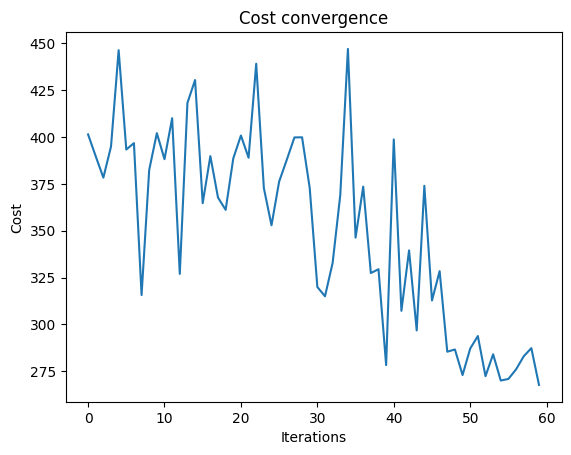

In [9]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

# Optimization Results

We can also examine the statistics of the algorithm. The optimization is always defined as a minimzation problem, so the positive maximization objective was tranlated to a negative minimization one by the Pyomo to qmod translator.

In order to get samples with the optimized parameters, we call the `sample` method:

In [10]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
1022,"{'w': [1, 2, 0], 'budget_rule_slack_var': [1, ...",0.000488,-4.5
847,"{'w': [2, 2, 2], 'budget_rule_slack_var': [0, ...",0.000488,-4.4
367,"{'w': [0, 3, 0], 'budget_rule_slack_var': [1, ...",0.000977,-3.9
101,"{'w': [1, 3, 1], 'budget_rule_slack_var': [1, ...",0.001465,-3.7
1023,"{'w': [2, 1, 0], 'budget_rule_slack_var': [0, ...",0.000488,-3.5


We will also want to compare the optimized results to uniformly sampled results:

In [11]:
uniform_result = combi.sample_uniform()

And compare the histograms:

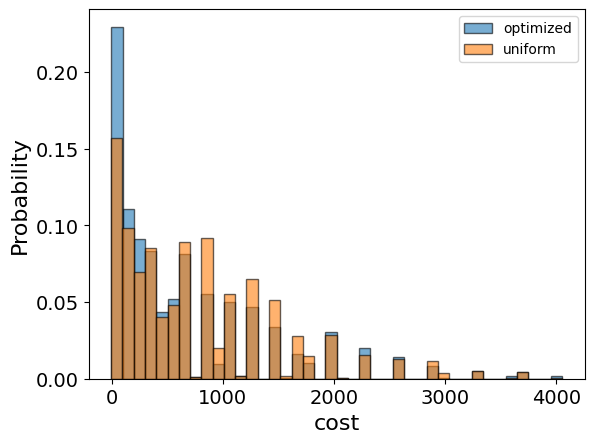

In [12]:
optimization_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

In [42]:
best_solution = optimization_result.loc[optimization_result.cost.idxmin()]
print(
    "x =",
    best_solution.solution["w"],
    ", cost =",
    best_solution.cost,
)

x = [3, 1, 2] , cost = -4.6


Lastly, we can compare to the classical solution of the problem:

In [43]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(portfolio_model)

portfolio_model.display()
classical_solution = [
    round(pyo.value(portfolio_model.w[i])) for i in range(len(portfolio_model.w))
]
print("Classical solution:", classical_solution)

Model portfolio_optimization

  Variables:
    w : Size=3, Index=w_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   2.0 :     6 : False : False : Integers
          1 :     0 :   1.0 :     6 : False : False : Integers
          2 :     0 :   1.0 :     6 : False : False : Integers

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : -4.800000000000001

  Constraints:
    budget_rule : Size=1
        Key  : Lower : Body : Upper
        None :  None :  4.0 :   6.0
Classical solution: [2, 1, 1]


We can see that most of the solutions obtained by running QAOA are close to the minimal solution obtained classically, demonstrating the effectiveness of the algorithm. Also, note the non-trivial solution which includes a non-zero weight for the asset with negative expected return, demonstrating that it sometimes makes sense to include such assets in the portfolio as a risk-mitigation strategy - especially if they are highly anti-correlated with the rest of the assets.


## References

<a id='PortfolioWiki'>[1]</a>: [Portfolio Optimization (Wikipedia)](https://en.wikipedia.org/wiki/Portfolio_optimization)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
